<div style="border:solid Chocolate 2px; padding: 40px">
<b>Привет, Савва!👋</b>
    
Меня зовут Зуева Юлия, можно просто Юля 😏 Я буду ревьюером твоего проекта. Предлагаю обращаться на "ты", но если это неудобно, пожалуйста, скажи об этом!
    
Моя основная цель - помочь тебе стать компетентным Data Scientist'ом: вместе преодолеть трудности и еще больше развить твои сильные навыки 💪 Очень постараюсь сделать это как можно быстрее :) В твоей работе я оставила комментарии, которые должны в этом помочь. Для твоего удобства комментарии расскрашены разными цветами: 
<br/>
<div class="alert alert-success">
<b>Все отлично!👍:</b> В случае, если решение на отдельном шаге является полностью правильным, или если я посчитаю нужным тебя за что-то похвалить. На такие решения можно опираться в будущих проектах.
</div>
<div class="alert alert-warning">
<b>Некоторые замечания и рекомендации💡:</b> В случае, когда решение на отдельном шаге станет еще лучше, если внести небольшие коррективы. Ты можешь учесть эти комментарии при выполнении будущих заданий или доработать проект сейчас (однако это не обязательно).
</div>
<div class="alert alert-block alert-danger">
<b>На доработку🤔:</b>
 В случае, когда решение на отдельном шаге требует существенной переработки и внесения правок. Напоминаю, что проект не может быть принят с первого раза, если ревью содержит комментарии, рекомендующие доработать шаги.
</div>
    
Чтобы наша с тобой работа была еще эффективнее, ты точно так же можешь оставлять комментарии и задавать мне вопросы. Для таких случаев, пожалуйста, выбери собственное оформление комментариев, которое будет отличаться от моего, чтобы не создавалась путаница. По этой же причине попрошу тебя не удалять и не изменять мои комментарии. Все это позволит лучше ориентироваться в нашем с тобой диалоге, а повторную проверку (в случае ее необходимости) выполнять оперативнее 🚀
    
Не спеши расстраиваться, если что-то не удалось с первого раза. Вместе мы обязательно разберемся со всеми трудностями! 🤓

# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Название проекта: "Прогнозирование стоимости автомобилей на основе их характеристик".

Цель проекта: построить модель, которая будет предсказывать стоимость автомобиля, при этом сочетая в себе такие качества, как: скорость, точность.

На вход поступает датасет с характеристиками автомобилей, которые мы должны предварительно обработать, рассмотрев дубликаты и аномалии. Затем необходимо будет закодировать категориальные переменные и масштабировать количественные, если в этом будет необходимость.

В последствии мы будем обучать различные ансамбли, смотреть на результаты: метрику качества (корень из MSE) и скорость обучения.

Подберем гиперпараметры с помощью GSCV, проверим метрики на кросс-валидации, прежде чем работать с тестовой выборкой.

## Подготовка данных

# Предобработка данных

In [1]:
!pip install category_encoders -q

In [2]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import time
from category_encoders import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer

In [3]:
def describe_df(DataFrame):

    binary_feats = [col for col in DataFrame.columns if DataFrame[col].nunique() <= 2]
    categorical_feats = [col for col in DataFrame.columns if DataFrame[col].dtype == 'object' and col not in binary_feats]
    continuous_feats = [col for col in DataFrame.columns if DataFrame[col].dtype != 'object' and col not in binary_feats]

    print('Бинарные переменные:', binary_feats)
    print('Категориальные переменные:', categorical_feats)
    print('Количественные переменные:', continuous_feats, '\n')

    print('Количество столбцов:', DataFrame.shape[1])
    print('Количество строк:', DataFrame.shape[0], '\n')

    print('Пропуски:\n')
    print(DataFrame.isna().sum(),'\n')
    print('Дубликаты:', DataFrame.duplicated().sum(),'\n')
    print(f'\nТипы данных: \n{DataFrame.dtypes}')

    print('Описание:\n')
    display(DataFrame.describe())
    print()

    print('Dataframe начало\n')
    display(DataFrame.head())
    print()
    print('Dataframe конец\n')
    display(DataFrame.tail())

In [4]:
autos = pd.read_csv('/datasets/autos.csv')
autos.name = 'autos'

In [5]:
describe_df(autos)

Бинарные переменные: ['Gearbox', 'Repaired', 'NumberOfPictures']
Категориальные переменные: ['DateCrawled', 'VehicleType', 'Model', 'FuelType', 'Brand', 'DateCreated', 'LastSeen']
Количественные переменные: ['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth', 'PostalCode'] 

Количество столбцов: 16
Количество строк: 354369 

Пропуски:

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64 

Дубликаты: 4 


Типы данных: 
DateCrawled          object
Price                 int64
VehicleType          object
RegistrationYear      int64
Gearbox              object
Power                 int

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000



Dataframe начало



,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21



Dataframe конец



,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26
354368,2016-03-20 19:41:08,3400,wagon,2002,manual,100,golf,150000,6,gasoline,volkswagen,NaN,2016-03-20 00:00:00,0,40764,2016-03-24 12:45:21


Видим, что в датасете 16 столбцов и 354369 наблюдений. 

Переменные распределены следующим образом:

Бинарные переменные: ['Gearbox', 'Repaired', 'NumberOfPictures']

Категориальные переменные: ['DateCrawled', 'VehicleType', 'Model', 'FuelType', 'Brand', 'DateCreated', 'LastSeen']

Количественные переменные: ['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth', 'PostalCode']

Замечены пропуски в двух бинарных переменных и в трех категориальных. Также наблюдается 4 дубликата, и названия в колонок не в змеином регистре.
В планах исправить эти недочеты.

<div class="alert alert-success">
<h3> Комментарий ревьюера <a class="tocSkip"> </h3> 
    
<b>Все отлично! 👍:</b> Отлично, первичную картину о данных составили, можем переходить к более детальной их проработке!

In [6]:
autos = autos.drop_duplicates().reset_index(drop=True)

In [7]:
autos['VehicleType'].value_counts()

sedan          91457
small          79830
wagon          65165
bus            28775
convertible    20203
coupe          16161
suv            11996
other           3288
Name: VehicleType, dtype: int64

In [8]:
autos['Gearbox'].value_counts()

manual    268249
auto       66283
Name: Gearbox, dtype: int64

In [9]:
autos['Model'].value_counts()

golf                  29232
other                 24420
3er                   19761
polo                  13066
corsa                 12570
                      ...  
i3                        8
rangerover                4
serie_3                   4
serie_1                   2
range_rover_evoque        2
Name: Model, Length: 250, dtype: int64

In [10]:
autos['FuelType'].value_counts()

petrol      216349
gasoline     98719
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

In [11]:
autos['Repaired'].value_counts()

no     247158
yes     36053
Name: Repaired, dtype: int64

In [12]:
autos['Repaired'] = autos['Repaired'].fillna('no')
autos["VehicleType"] = autos["VehicleType"].fillna(autos["VehicleType"].mode().values[0])
autos["Gearbox"] = autos["Gearbox"].fillna(autos["Gearbox"].mode().values[0])
autos["Model"] = autos["Model"].fillna(autos["Model"].mode().values[0])
autos["FuelType"] = autos["FuelType"].fillna(autos["FuelType"].mode().values[0])

<div class="alert alert-warning">
<h3> Комментарий ревьюера <a class="tocSkip"> </h3>
    
<b>Некоторые замечания и рекомендации💡:</b> 
    
* На мой взгляд, заполнять пропуски в Repaired значением "no" не совсем корректно, поскольку какие-то из этих автомобилей вполне могли быть в ремонте, но их цена будет завышаться за счет тех, которые на самом деле не были. Кажется, в данном случае было бы уместнее выделить третью группу "unknown".
    
    
* Относительно остальных признаков: в целом это тоже допустимый вариант заполнения, однако для некоторых признаков также имеется возможность довольно точно восстановить их значения, вместо засорения часто не соответсвующими истине значениями моды. Для этого мы можем изучить корреляцию данных признаков между собой и задействовать обнаруженную тесную взаимосвязь, чтобы заполнить пропуски самыми частовстречаемыми представителями внутри той или иной группы (например, VehicleType по модели и бренду). Чтобы посчитать корреляцию, можно использовать <a href = 'https://towardsdatascience.com/phik-k-get-familiar-with-the-latest-correlation-coefficient-9ba0032b37e7/'>Phik</a>.
    
    
* Для заполнения по группе удобно использовать <a href='https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.transform.html'>transform</a>. Применив его к сгруппированным данным, мы можем сказать ему, какой показатель нам необходимо определить, и он определит его для каждой строки датасета в соответсвии с его группой. Затем мы можем использовать данный вектор для заполнения пропусков через `fillna`.

In [13]:
autos.columns = autos.columns.str.lower()

In [14]:
autos = autos.rename(columns={'datecrawled':'date_crawled', 
                        'vehicletype':'vehicle_type', 
                        'registrationyear':'registration_year', 
                        'registrationmonth':'registration_month', 
                        'fueltype':'fuel_type', 
                        'datecreated':'date_created',
                        'numberofpictures': 'number_of_pictures',
                        'postalcode':'postal_code',
                        'lastseen':'last_seen'})

<div class="alert alert-warning">
<h3> Комментарий ревьюера <a class="tocSkip"> </h3>
    
<b>Некоторые замечания и рекомендации💡:</b> Данный шаг уместнее производить в самом начале обработки данных. Иначе у нас половина работы идет с одним неймингом, к которому мы привыкаем, а потом внезапно с другим.

In [15]:
describe_df(autos)

Бинарные переменные: ['gearbox', 'repaired', 'number_of_pictures']
Категориальные переменные: ['date_crawled', 'vehicle_type', 'model', 'fuel_type', 'brand', 'date_created', 'last_seen']
Количественные переменные: ['price', 'registration_year', 'power', 'kilometer', 'registration_month', 'postal_code'] 

Количество столбцов: 16
Количество строк: 354365 

Пропуски:

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
date_created          0
number_of_pictures    0
postal_code           0
last_seen             0
dtype: int64 

Дубликаты: 1 


Типы данных: 
date_crawled          object
price                  int64
vehicle_type          object
registration_year      int64
gearbox               object
power                  int64
model                 object


,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000,354365.0,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989,5.714650,0.0,50508.503800
std,4514.176349,90.228466,189.851330,37905.083858,3.726432,0.0,25783.100078
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000



Dataframe начало



,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,sedan,1993,manual,0,golf,150000,0,petrol,volkswagen,no,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,golf,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21



Dataframe конец



,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
354360,2016-03-21 09:50:58,0,sedan,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354361,2016-03-14 17:48:27,2200,sedan,2005,manual,0,golf,20000,1,petrol,sonstige_autos,no,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354362,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354363,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26
354364,2016-03-20 19:41:08,3400,wagon,2002,manual,100,golf,150000,6,gasoline,volkswagen,no,2016-03-20 00:00:00,0,40764,2016-03-24 12:45:21


Предобработка данных завершена, дубликаты удалены, пропуски заполнены модальными значениями.

Удаление пропусков было бы некорректным, так как их было чересчур много.

# Исследовательский анализ

In [16]:
autos = autos.drop(["date_crawled","date_created","last_seen","number_of_pictures","postal_code", "registration_month"],axis = 1)

<div class="alert alert-warning">
<h3> Комментарий ревьюера <a class="tocSkip"> </h3>
    
<b>Некоторые замечания и рекомендации💡:</b> В целом согласна, в текущем виде данные признаки не принесут особой пользы. Но в то же время они могут помочь сделать анализ более глубоким и точным.
    
<details> <summary> <span style='color:blue' > Развернуть подробнее. </span> </summary>
    
1. Даты могут быть использованы для проверки записей на корректность порядка событий. Если создание анкеты предшествует времени регистрации автомобиля, то такие объявления можно считать подозрительными.
    

2. В разных географических регионах может быть разный уровень жизни, что так же будет влиять на стоимость. Чтобы это учесть, нам не обязательно иметь средние показатели по регионам, модель самостоятельно сможет распознать, имеется ли какая-то связь цены автомобиля с тем регионом, в котором он продается. Единственное - у нас довольно много уникальных значений индекса, что будет тяжеловато обработать, но мы можем взять первые несколько цифр индекса, чтобы очеретить только какие-то более менее крупные территории.

</details>

Удаляем неинформативные переменные, так как они будут мешать обучению

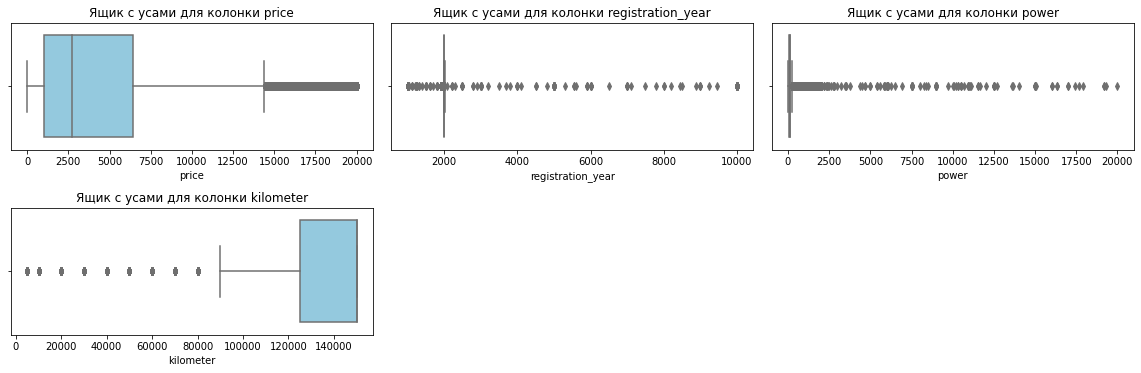

In [17]:
numerical_columns = ['price', 'registration_year', 'power', 'kilometer', 'registration_month']

plt.figure(figsize=(16, 10))

for i, column in enumerate(numerical_columns, 1):
    if column in autos.columns:
        plt.subplot(4, 3, i)
        sns.boxplot(x=autos[column], color='skyblue')
        plt.title(f'Ящик с усами для колонки {column}')
        plt.xlabel(column)

plt.tight_layout()
plt.show()

Очевидно большое количество аномалий в количественных переменных, также в колонке registration_month почему-то фигурирует число 0.

Для начала избавимся от черечур мощных значений лошадиных сил в двигателе, также можем обработать значения в колонке с датой регистрации.

In [18]:
autos = autos.loc[(autos['registration_year'] <= 2016) & (autos['registration_year'] >= 1900)]

In [19]:
autos = autos.loc[autos['power'] <= 1000]

In [20]:
autos = autos.loc[autos['price'] > 0]

<div class="alert alert-warning">
<h3> Комментарий ревьюера <a class="tocSkip"> </h3>
    
<b>Некоторые замечания и рекомендации💡:</b>
    
* Нетипичные значения мощности (сюда еще можно включить и подозрительно низкий) тоже можно попробовать восстановить с учетом прочих характеристик автомобиля.
    
    
* Месяц - котрый по своей сути является категориальным, а не количественным - скорее всего, малоинформативный признак (едва ли от него зависит значение цены), поэтому от него в целом тоже можно избавиться.

In [21]:
autos['fuel_type'] = autos['fuel_type'].replace(['gasoline'],'petrol')

In [22]:
describe_df(autos)

Бинарные переменные: ['gearbox', 'repaired']
Категориальные переменные: ['vehicle_type', 'model', 'fuel_type', 'brand']
Количественные переменные: ['price', 'registration_year', 'power', 'kilometer'] 

Количество столбцов: 10
Количество строк: 329499 

Пропуски:

price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
repaired             0
dtype: int64 

Дубликаты: 54900 


Типы данных: 
price                 int64
vehicle_type         object
registration_year     int64
gearbox              object
power                 int64
model                object
kilometer             int64
fuel_type            object
brand                object
repaired             object
dtype: object
Описание:



,price,registration_year,power,kilometer
count,329499.000000,329499.000000,329499.00000,329499.000000
mean,4608.182307,2002.594648,108.68538,128207.566639
std,4546.889190,6.927703,63.38386,37518.805410
min,1.000000,1910.000000,0.00000,5000.000000
25%,1200.000000,1999.000000,71.00000,125000.000000
50%,2900.000000,2003.000000,105.00000,150000.000000
75%,6600.000000,2007.000000,143.00000,150000.000000
max,20000.000000,2016.000000,1000.00000,150000.000000



Dataframe начало



,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,sedan,1993,manual,0,golf,150000,petrol,volkswagen,no
1,18300,coupe,2011,manual,190,golf,125000,petrol,audi,yes
2,9800,suv,2004,auto,163,grand,125000,petrol,jeep,no
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,petrol,skoda,no



Dataframe конец



,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
354359,1150,bus,2000,manual,0,zafira,150000,petrol,opel,no
354361,2200,sedan,2005,manual,0,golf,20000,petrol,sonstige_autos,no
354362,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354363,9200,bus,1996,manual,102,transporter,150000,petrol,volkswagen,no
354364,3400,wagon,2002,manual,100,golf,150000,petrol,volkswagen,no


<div class="alert alert-block alert-danger">
<h3> Комментарий ревьюера <a class="tocSkip"></h3>

<b>На доработку🤔:</b> Обрати внимание, что при удалении дубликатов в данном случае ты учитываешь только ту информацию, которая вполне может повторяться в реальном мире. Удаляя такие одинаковые наблюдения, мы вмешиваемся в репрезентативность нашей выборки. Поскольку искажается частота тех или иных наблюдений, все представители выборки становятся равновероятными, из-за чего модель в свою очередь иначе распределяет веса, определяющие влияние того или иного фактора. Шаг по обработке дубликатов стоит проводить до начала каких-либо статистических расчетов, иначе они будут искажены. В нашем случае при работе с дубликатами стоит также учитывать более специфическую информацию об объявлении (даты, почтовый индекс), чтобы удалить задублировавшиеся объявления, а не авто.

<div class="alert alert-success">
<h3> Комментарий ревьюера 2<a class="tocSkip"> </h3> 
    
<b>Все отлично! 👍:</b> 😉

Исследовательский анализ завершен, осталось около 330 тысяч строк, 10 колонок.

<div class="alert alert-warning">
<h3> Комментарий ревьюера <a class="tocSkip"> </h3>
    
<b>Некоторые замечания и рекомендации💡:</b> 
    
* На данном этапе также можно было бы чуть углубиться в анализ того, как данные взаимосвязаны между собой, изучив корреляцию. Чтобы посчитать корреляцию, можно использовать <a href = 'https://towardsdatascience.com/phik-k-get-familiar-with-the-latest-correlation-coefficient-9ba0032b37e7/'>Phik</a>.
    
    
* Мультиколоинеарность (скоррелированности признаков между собой) является проблемой в случаях интерпретации важности или степени влияния признака на таргет (скоррелированные признаки оказывают на таргет схожий между собой эффект - то есть объяснятся примерно одна и та же вариация таргета - из-за чего и оценка этого влияния размазывается между этими признаками, то есть сам по себе эффект может быть значительным, но из-за того, что распределен между несколькими признаками, они могут начать проигрывать в рейтинге самых влияетельных факторов). Кроме того, наличие мультиколлинеарности приводит к увеличению вычислительной сложности модели - в совокупности с малой дополнительно приносимой пользой (редко признаки скорредированы на все 100%, что-то индивидуально они все же тоже привносят) это может быть существенным минусом, когда время работы модели играет не последнюю роль - наш случай. Поэтому можно задуматься о том, чтобы побороться с мультиколлинеарностью, например, объединить сильно скоррелированные категориальные признаки в один.

## Обучение моделей

In [23]:
categorical_cols = ['vehicle_type', 'gearbox', 'fuel_type', 'brand', 'model', 'repaired']

In [24]:
X = autos.drop('price', axis=1)
y = autos['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [25]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

<div class="alert alert-warning">
<h3> Комментарий ревьюера 2<a class="tocSkip"> </h3>
    
<b>Некоторые замечания и рекомендации💡:</b> У алгоритмов гридсерча и кросс-валидации из sklearn есть встроенная метрика `"neg_root_mean_squared_error"`.

In [26]:
rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [27]:
rf_pipeline = Pipeline([
    ('encoder', TargetEncoder(cols=categorical_cols)),
    ('model', RandomForestRegressor(random_state=42))
])

In [28]:
lgb_encoder = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse=False), categorical_cols)
])
lgb_pipeline = Pipeline([
    ('encoder', lgb_encoder),
    ('model', lgb.LGBMRegressor(random_state=42))
])


<div class="alert alert-warning">
<h3> Комментарий ревьюера 2<a class="tocSkip"> </h3>
    
<b>Некоторые замечания и рекомендации💡:</b> 
    
* Про OHE говорила скорее в контексте линейной регрессии в данном проекте, либо максимум для признаков с небольшим количеством категорий. Иначе пространство признаков слишком раздувается, и моделям на основе деревьев (lgbm к ним относится) становится тяжело их обработать.
    
    
* Не забывай про `drop='First'`, чтобы не плодить еще больше лишних признаков.

In [29]:
cat_pipeline = Pipeline([
    ('encoder', FunctionTransformer(lambda x: x, validate=False)),
    ('model', CatBoostRegressor(random_state=42, verbose=0, cat_features=categorical_cols))
])

In [30]:
param_grid_rf = {
    'encoder__smoothing': [1, 5, 10],  # регуляризация при кодировании
    'model__n_estimators': [50, 100],
    'model__max_depth': [10, None]
}

In [31]:
grid_rf = GridSearchCV(
    rf_pipeline,
    param_grid=param_grid_rf,
    scoring=rmse_scorer,
    cv=5,
    n_jobs=-1,
    refit=True,
    verbose=1
)

In [32]:
start_time = time.time()
grid_rf.fit(X_train, y_train)
rf_tuning_time = time.time() - start_time

print(f"\nВремя подбора гиперпараметров для RandomForest: {rf_tuning_time:.2f} сек")
print("Лучшие параметры для RF:", grid_rf.best_params_)
best_rf_cv_score = abs(grid_rf.best_score_)
print(f"Лучшая средняя RMSE (CV) для RF: {best_rf_cv_score:.2f}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits

Время подбора гиперпараметров для RandomForest: 1689.44 сек
Лучшие параметры для RF: {'encoder__smoothing': 5, 'model__max_depth': None, 'model__n_estimators': 100}
Лучшая средняя RMSE (CV) для RF: 1645.19


In [33]:
best_rf_pipeline = grid_rf.best_estimator_

In [34]:
def evaluate_pipeline(pipeline, X, y, cv=5):
    cv_results = cross_validate(
        pipeline,
        X,
        y,
        scoring=rmse_scorer,
        cv=cv,
        return_train_score=False,
        n_jobs=-1
    )
    mean_rmse = abs(cv_results['test_score'].mean())
    mean_fit_time = cv_results['fit_time'].mean()
    mean_score_time = cv_results['score_time'].mean()
    return mean_rmse, mean_fit_time, mean_score_time

In [35]:
rf_cv_rmse, rf_cv_fit_time, rf_cv_score_time = evaluate_pipeline(best_rf_pipeline, X_train, y_train)
lgb_cv_rmse, lgb_cv_fit_time, lgb_cv_score_time = evaluate_pipeline(lgb_pipeline, X_train, y_train)
cat_cv_rmse, cat_cv_fit_time, cat_cv_score_time = evaluate_pipeline(cat_pipeline, X_train, y_train)

## Анализ моделей

In [36]:
results_summary = pd.DataFrame({
    'Model': ['RandomForest (TargetEncoder)', 'LightGBM (OneHotEncoder)', 'CatBoost (Identity)'],
    'CV Mean RMSE': [rf_cv_rmse, lgb_cv_rmse, cat_cv_rmse],
    'CV Mean Fit Time (sec)': [rf_cv_fit_time, lgb_cv_fit_time, cat_cv_fit_time],
    'CV Mean Score Time (sec)': [rf_cv_score_time, lgb_cv_score_time, cat_cv_score_time]
})
print("\nСводная таблица результатов кросс-валидации:")
display(results_summary)


Сводная таблица результатов кросс-валидации:


,Model,CV Mean RMSE,CV Mean Fit Time (sec),CV Mean Score Time (sec)
0,RandomForest (TargetEncoder),1645.192385,45.034978,2.033121
1,LightGBM (OneHotEncoder),3584.687418,6.038776,0.958535
2,CatBoost (Identity),1666.250950,142.069715,0.337421


In [37]:
start_time = time.time()
best_rf_pipeline.fit(X_train, y_train)
final_fit_time = time.time() - start_time

In [38]:
start_time = time.time()
y_pred_test = best_rf_pipeline.predict(X_test)
final_pred_time = time.time() - start_time
final_rmse = rmse(y_test, y_pred_test)

In [39]:
print("\n--- Итоговая оценка на тестовой выборке для RF (TargetEncoder) ---")
print(f"Время дообучения: {final_fit_time:.2f} сек")
print(f"Время предсказания: {final_pred_time:.4f} сек")
print(f"Test RMSE: {final_rmse:.2f}")


--- Итоговая оценка на тестовой выборке для RF (TargetEncoder) ---
Время дообучения: 56.26 сек
Время предсказания: 3.2668 сек
Test RMSE: 1603.04


<div class="alert alert-warning">
<h3> Комментарий ревьюера <a class="tocSkip"> </h3>
    
<b>Некоторые замечания и рекомендации💡:</b> 
    
* Производить кодирование до разбиения на выборки не совсем корректный подход, это создает ряд потенциальных проблем, связанных с тем, как модель будет обращаться с новыми категориями, которые не попали в обучающую выборку. Если такая категория сейчас окажется в тестовом наборе, ошибка не всплывет. Однако впоследствии, когда модель будет применяться на практике, появившаяся новая категория сломает ее работу.
    
    Чтобы такого не происходило, необходимо придерживаться принципа: обрабатывать тест с учетом трейна, но не допускать участие теста в обработке трейна (аналогично с ввалидационными выборками), при этом использовать специальные функции для кодирования, у которых в параметрах можно задать, как обращаться с новыми категориями. Например, для порядкового кодирования: `encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)`.
    
    
* В сравнении с `get_dummies` более корректным, профессиональным и удобным сопособом кодирования является использование <a href = 'https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html'>OHE</a> от sklearn, который имеет методы fit, transform, имеет параметры для настройки работы с новыми категориями, удобно встраивается в пайплайн обучения. Подробнее с особенностями и различием get_dummies и OHE можно ознакомиться в этом <a href = 'https://colab.research.google.com/drive/1_gAMXcQKoCShB_l8FNtYEejMnosm9mvt?usp=sharing'>ноутбуке</a>.
    
    
* Теперь относительно выбора типа кодирования. Обрати внимание на этот пункт, поскольку дамми-кодирование для деревьев в данном случае далеко не самый удачный вариант, тормозящий процесс обучения, а время работы в нашей задаче играет не последнюю роль.
    <details> <summary> <span style='color:blue' > Развернуть подробнее. </span> </summary>
        
    1. Для линейной регрессии допустимо только кодировние <a href = 'https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html'>OHE</a> (если категории не имеют порядка). Если применить порядковое кодирование к тем категориям, которые этого порядка по сути не имеют, то модель едва ли сможет нормально оценить влияние данного признака, поскольку будет искать линейную взаимосвязь там, где ее не подразумевается. По итогу признак становится бесполезным.
        
    2. Для простых деревьев, лесов и xgboost в случае, когда уникальных категорий немного (низкокардинальный признак), можно тоже применять OHE. Однако если признак высококардинальный (много уникальных категорий) от него лучше воздержаться. Для достижения хорошей точности в этом случае необходимо растить очень глубокое дерево, что достаточно ресурсозатратно. По этой причине такие деревья часто остаются недообученными и несбалансированными. Вместо OHE лучшим вариантом будет считаться <a href='https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.TargetEncoder.html'>TargetEncoder</a>. Однако данный подход требует регуляризации (например, разбиение на фолды, сглаживание), чтобы избежать утечки данных и переобучения. Это реализуется через кастомную функцию. Это не слишком сложно, но нужно подзаморочиться, в связи с чем пока можем остановить свой выбор на порядковом кодировании, которое в целом тоже допустимо, хоть и будет работать хуже.
    
    3. Самым оптимальным решением в случае lgbm и catboost будет указание списка категориальных признаков в спициальном параметре данных моделей (`categorical_feature` и `cat_features соответсвнно`). У данных моделей предусмотрены встроенные кодировщики (TargetEncoder у lgbm и собственный кодировщик у catboost), которые самостоятельно закодируют и сделают это корректно.
    <\details>
        
        
* При сравнении моделей предпочтительнее использовать кросс-валидационную оценку качества. Кросс-валидация позволяет получить более независимую взвешенную оценку модели, поскольку при подборе параметров мы не подстраивается под одну ограниченную зафиксированную валидационную выборку, вместо этого мы рассматриваем результаты разных подвыборок, то есть учитываем всю доступную нам вариативность данных. Однако обрати внимание, что в таком случае **все** модели должны быть оценены через кросс-валидацию, чтобы сравнение было честным.
        
        
* При проведении кросс-валидации по-хорошему стоит придерживаться тех же принципов обработки, что и при обработке теста и трейна - обрабатывать валидационную выборку на основе тренировочной и не допускать учета валидационных данных при обработке трейна. Если мы заранее обрабатываем трейн и тест, то этот принцип нарушается. Чтобы этого избежать, следует использовать <a href = 'https://scikit-learn.ru/6-1-pipelines-and-composite-estimators/'>пайплайны</a>, с помощью котороых можно задавать последовательность производимых действий (например, последовательность обработки количественных признаков, или пайплайн для обучения, который может содержать шаги обработки и саму модель на последнем шаге). Дополнительно для возможности применения в пайплайне того или иного метода к конкретному набору призанков тебе может понадобиться <a href = 'https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html'>ColumnTransformer</a>. С помощью него мы можем указать для какого списка признаков применить то или иное преобразование или пайплайн преобразований. 

<div class="alert alert-block alert-danger">
<h3> Комментарий ревьюера <a class="tocSkip"></h3>

<b>На доработку🤔:</b>
      
* Как минимум для одной модели должен быть произведен подбор параметров.
    
    
* Сейчас ты все модели сравниваешь между собой по тестовой метрике. Это допустимый вариант, который встречается на практике, но необходимо помнить, что таким образом мы в некотором плане "переобучаемся" - подстраиваем свой выбор под конкретный тестовый набор. Поэтому, по крайней мере в Практикуме, условились эмулировать так называемый вывод модели в прод - то есть тестовый набор мы откладываем для проверки на нем только самой лучшей модели (или нескольких лучших), которые мы пустили в прод, чтобы посмотреть, как они ведут себя в реальной среде, на новых данных. Выбор при этом условились производить на основе (кросс-) валидационных показателей, которые представляют из себя более взвешенную оценку, менее подверженную влиянию особенностей выборки (как в случае выбора на основе тестовых показателей).
    
    
* Для выбора лучшей модели в данном проекте также требуется использовать и время предсказания, сейчас оно не считается. Лучше всего будет составить сводную таблицу с валиадационными временеи и метриками для удобного сравнения этих показателей и принятия взвешенного решения. 
    
    Предлагаю отказаться от `%%time` - не очень удобный способ для фиксации времени с целью последующего сравнения данного показателя. Придется либо перелистывать туда-сюда проект, чтобы понять времязатраты той или иной модели, либо переносить все результаты в сводную таблицу вручную. Есть более удобные варианты: 
    
    <details> <summary> <span style='color:blue' > Развернуть подробнее. </span> </summary>
    
    1. Базовй модуль time (`import time`): `start = time.time()` позволит зафиксировать время в тот или иной момент процесса выполнения ячейки, аналогичным образом фиксируем второй момент - окончание того или иного процесса, разница между этими двумя зафиксированными моменами (в секундах), которую мы можем сохранить в переменную, и будет временем работы того или иного блока кода. Этот способ подойдет, если будешь использовать валидационные выборки.
    
    2. Если для сравнения будешь использовать кросс-валидацию:
    
        2.1. Если используешь для модели гридсерч, то из него сразу можно достать среднее время обучения (`mean_fit_time`) и оценки (`mean_score_time`) лучшей модели. Пример кода: `grid_cv.cv_results_['mean_fit_time'][grid_cv.best_index_]`. Однако следует уточнить, что mean_score_time включает не только время получения предсказаний, но и расчет метрики, но в нашем случае это допустимо.
    
        2.2. Если подбор параметров не производится, то можно провести кросс-валидацию с помощью <a href='https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html'>cross_validate</a>, который по аналогии с гридсерчем помимо скоров на каждом сплите также логирует время обучения и время получения скора (предикт + оценка метрики).
    

<div class="alert alert-warning">
<h3> Комментарий ревьюера <a class="tocSkip"> </h3>
    
<b>Некоторые замечания и рекомендации💡:</b> Дополнительно на этапе тестирования имеет смысл визуально сравнить предсказания с истиной чтобы лучше предстваить, чего же мы в итоге достигли. Также можем провести проверку итоговой модели на адекватность (в нашей задаче самой простой моделью можно считать, например, использование предыдущего значения).

# Итоговый вывод: 

Были загружены и предобработаны данные по характеристикам автомобилей.
Удалены дубликаты, пропуски заполнены модальными значениями, удалены неинформативные переменные, такие как: месяц регистрации автомобиля, дата создания анкеты, количество фотографий автомобиля, почтовый индекс владельца анкеты (пользователя), дата последней активности пользователя.

Категориальные переменные были закодированы с помощью OHE, Target Encoder.
С учётом сочетания качества (RMSE) и времени обучения/предсказания лучшей моделью в данном эксперименте оказалась Random Forest. Она даёт почти самую низкую ошибку на кросс-валидации(около 1645) и при этом тренируется быстрее остальных, несмотря на достаточно долгий подбор гиперпараметров.


<div class="alert alert-success">
<h3> Комментарий ревьюера <a class="tocSkip"> </h3> 
    
<b>Все отлично! 👍:</b> Супер, в целом с задачей справились!

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнена загрузка и подготовка данных
- [ ]  Выполнено обучение моделей
- [ ]  Есть анализ скорости работы и качества моделей

<div style="border:solid Chocolate 2px; padding: 40px">

**Общий вывод по проекту**

Савва, спасибо за твой проект! У тебя хорошая, достойная работа! Но есть еще моменты, которые требуют доработки.
    
Кратко пройдусь по впечатлениям. 

**Отмечу отдельные положительные моменты проекта🙂**:
 
* Прекрасное владение инструментами обработки данных!
* Все этапы работы проделаны очень осмысленно! Каждый шаг снабжен пояснениями и выводами!
* Работа имеет четкую структуру и выполнена аккуратно, проверять - одно удовольствие!

    
**На что стоит обратить внимание🤓**:
   
* Пересмотреть обработку дубликатов
* Провести подбор параметров хотя бы для одной модели.
* Сравнение моделей производить на основе (кросс-) валидационных метрик.
* При сравнении моделей учитывать время работы.

**Желаю удачи и жду твой проект на повторное ревью!**😉
    
<img src="https://99px.ru/sstorage/86/2015/12/image_86271215043043632690.gif" />

<div class="alert alert-success">
<b>Комментарий ревьюера 2:</b> Все критичные моменты исправлены, проект принимается! Было очень приятно с тобой поработать :) Желаю огромных успехов в дальнейшем обучении и карьерных достижений! 🍀